In [1]:

import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import pandas as pd
import scipy.stats
import seaborn as sns
import scipy.stats as st

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling

In [2]:
path_to_file = '/Users/mac/Desktop/Workshop1/water_potability.csv'
source_df = pd.read_csv(path_to_file, engine='python')
source_df.dropna(inplace=True)
source_df.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


In [3]:

def inverse_transform_sampling(data, n_bins=40, n_samples=1000):
    bins = distributions._freedman_diaconis_bins(data.values)
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r),bins

In [4]:
variables = source_df[['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity']]
targets = source_df[['Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']]

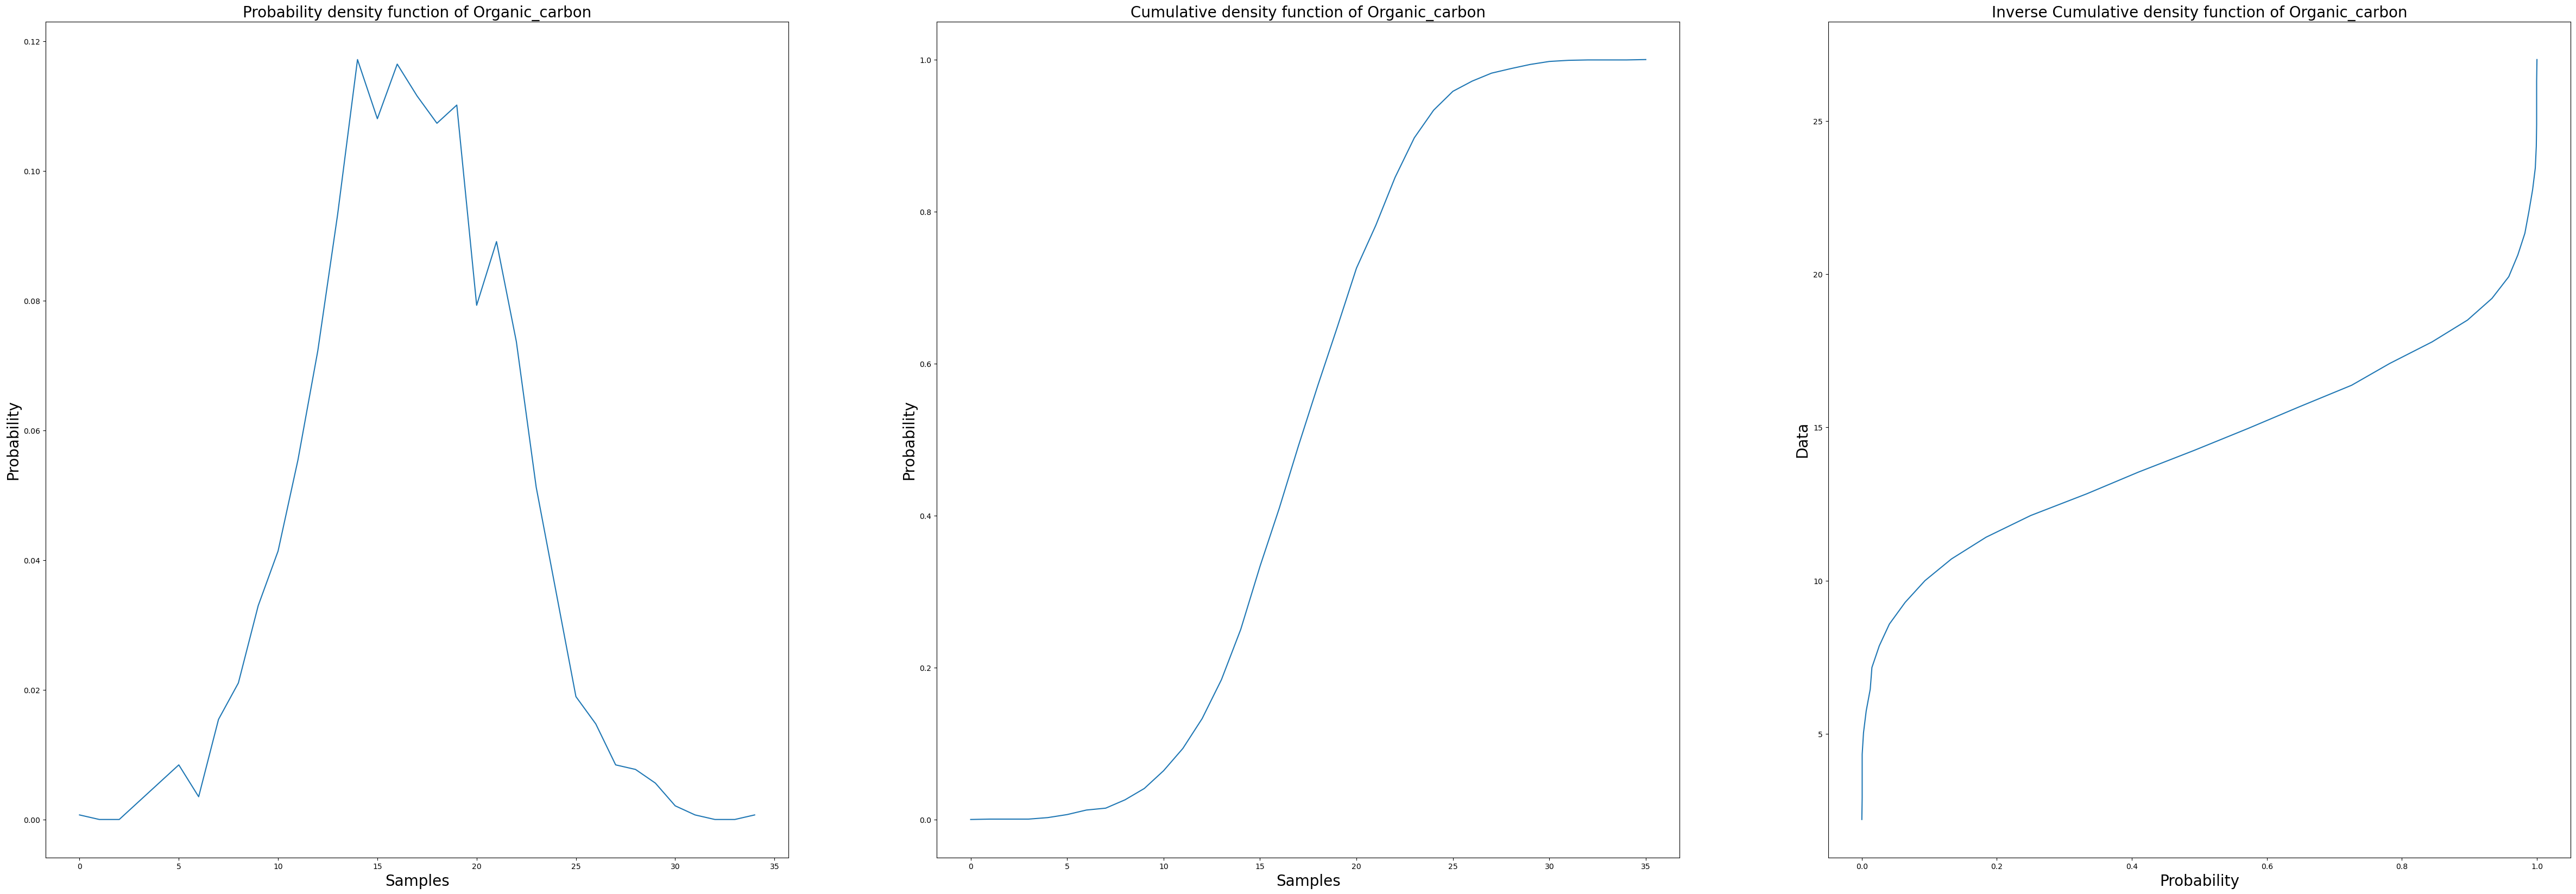

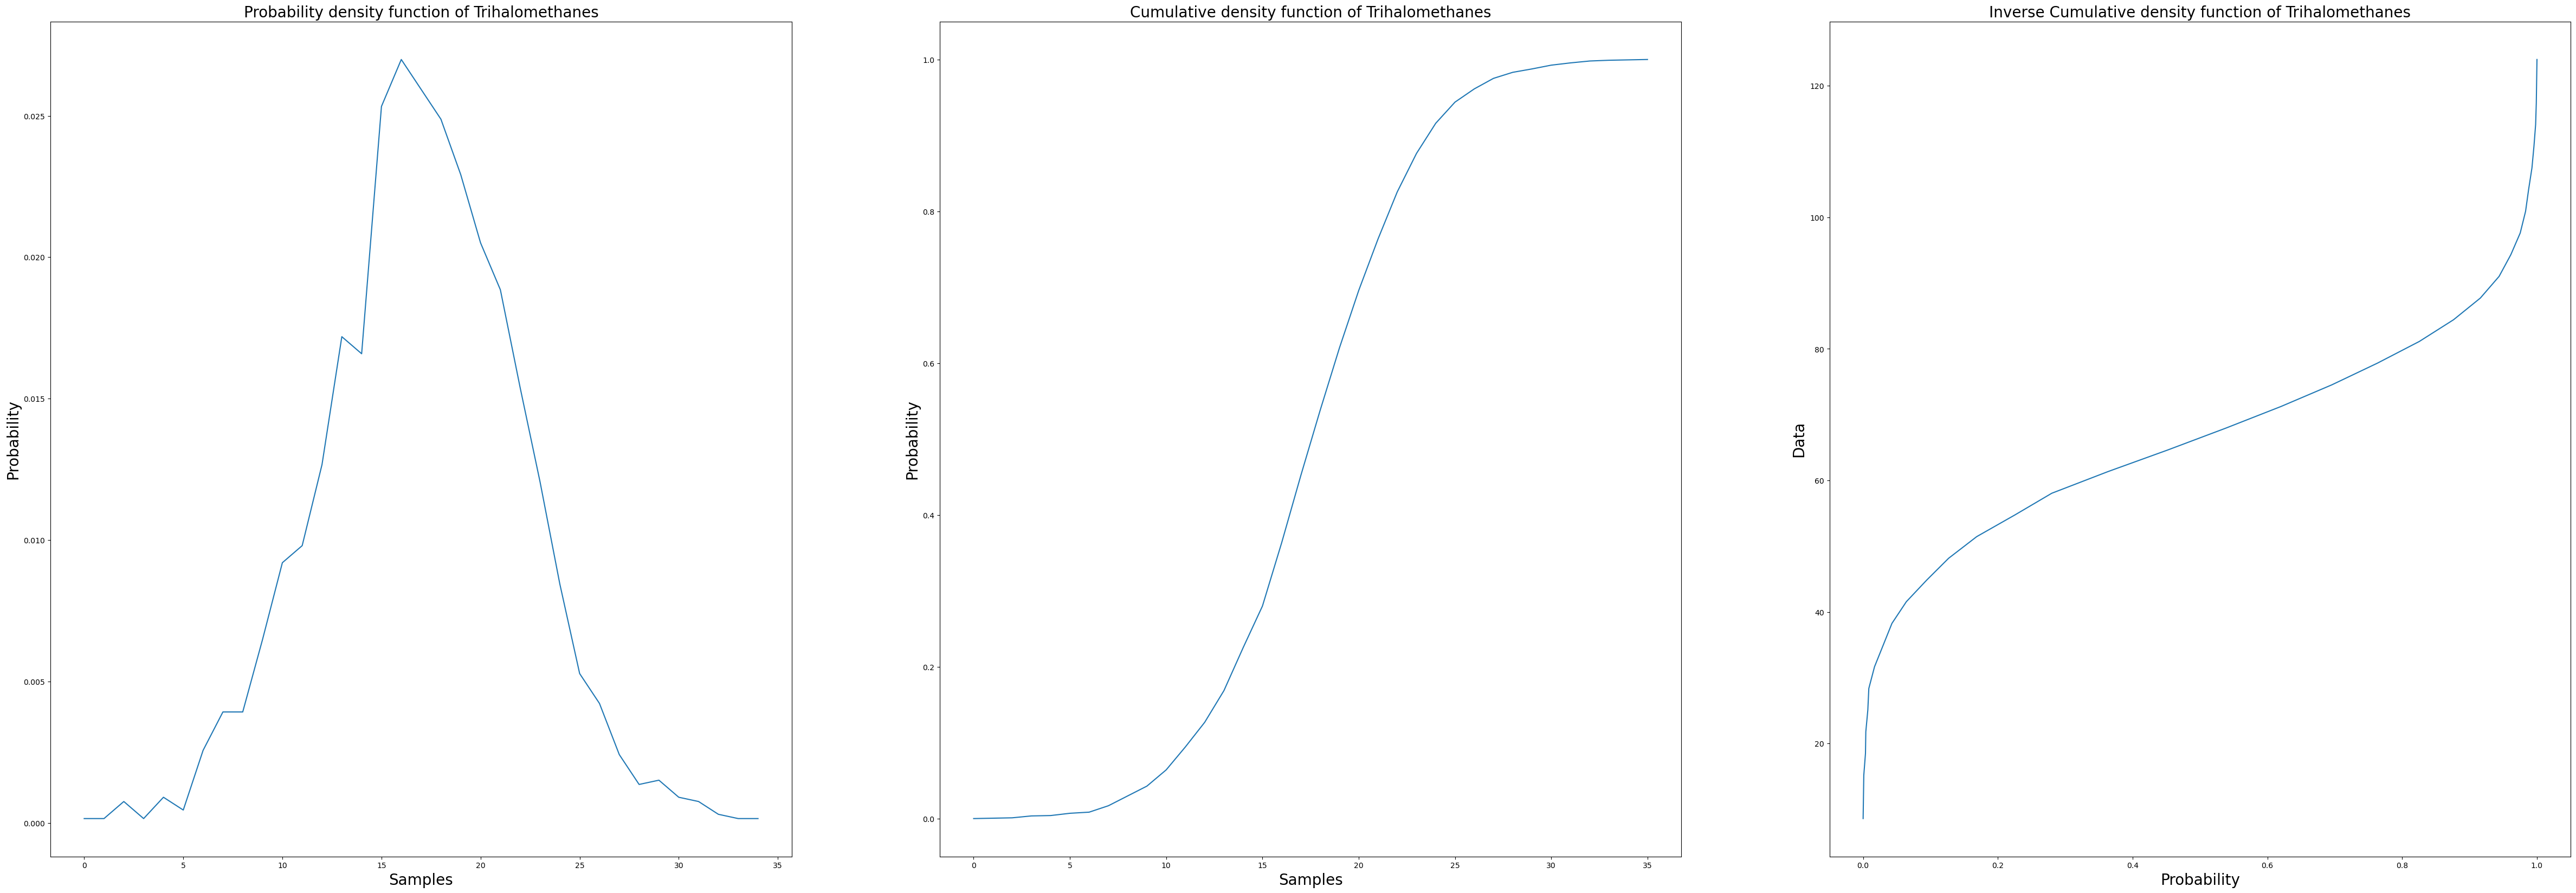

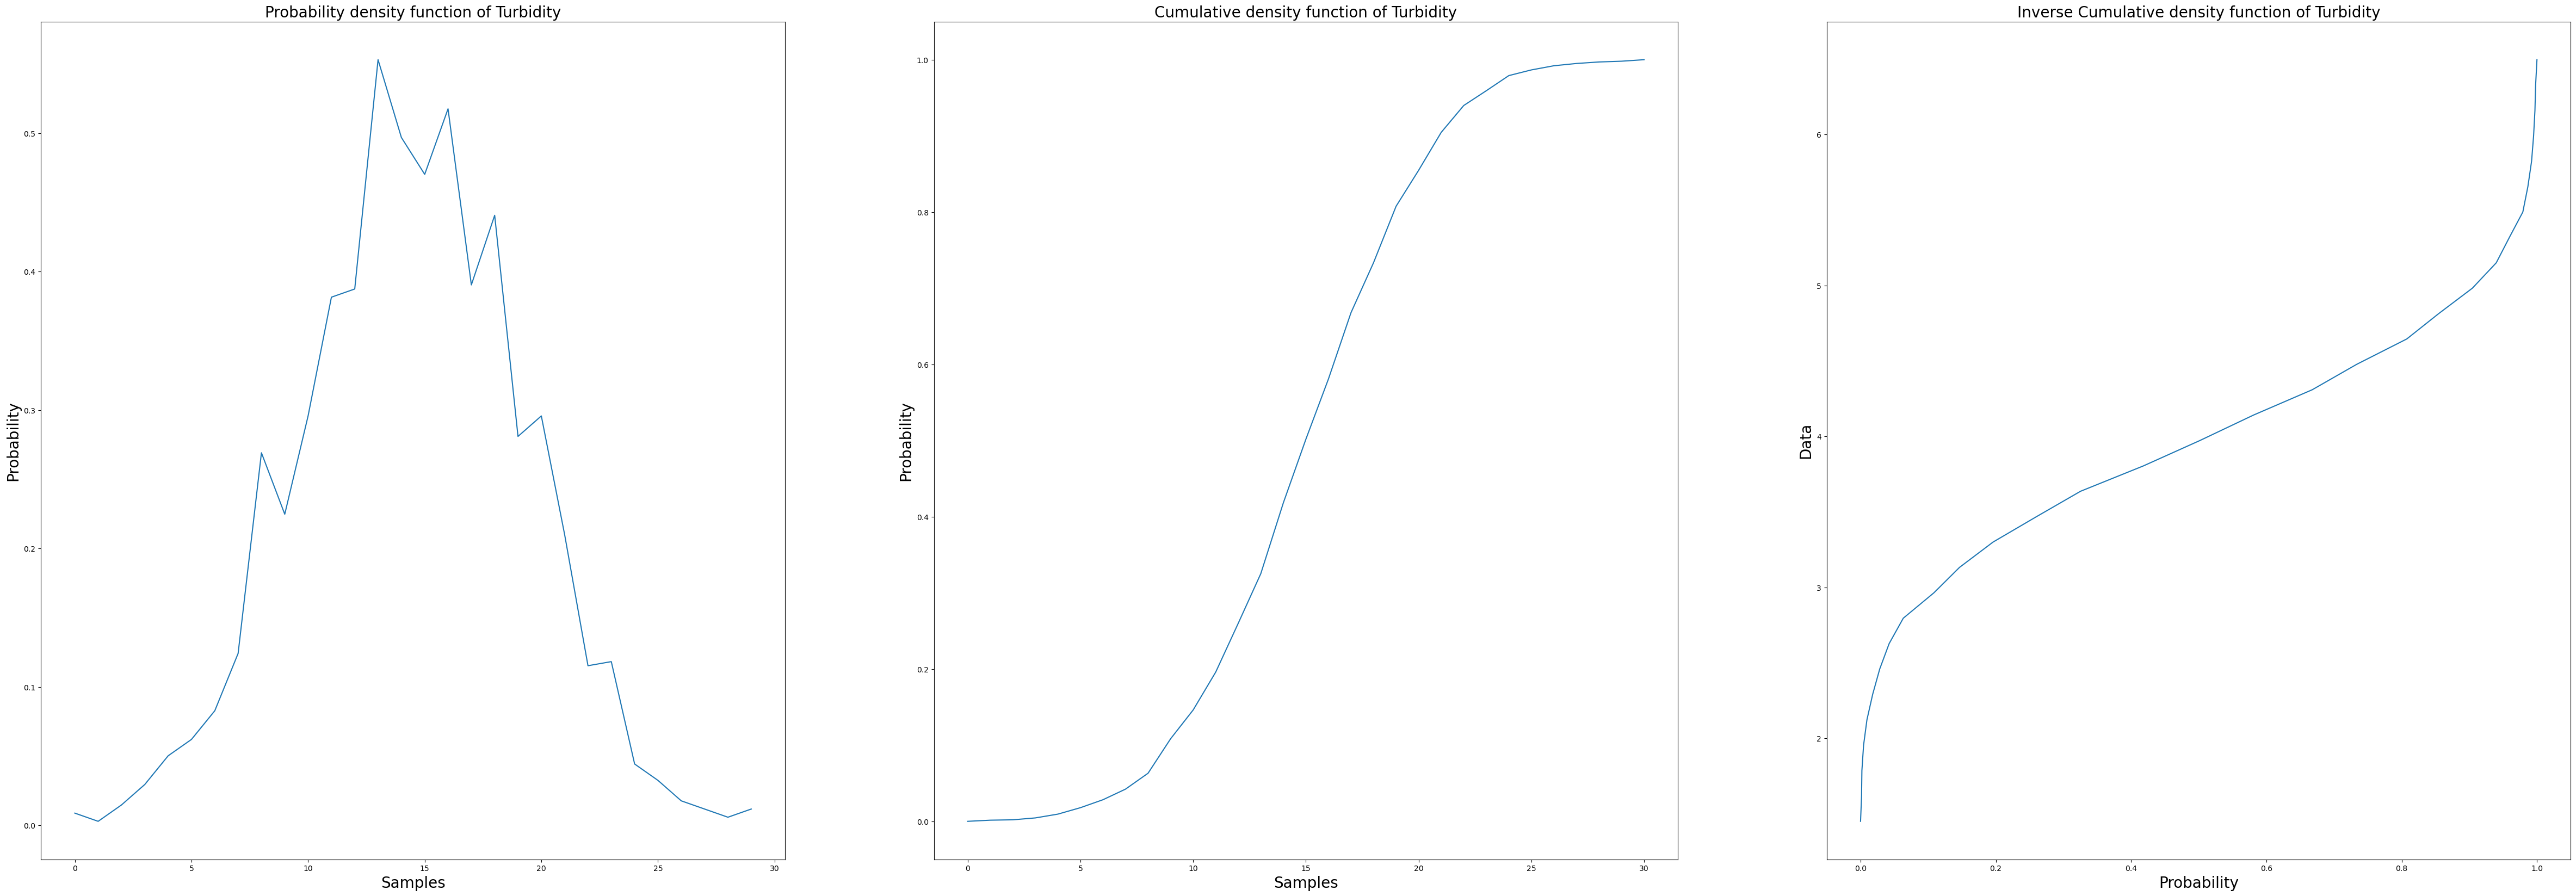

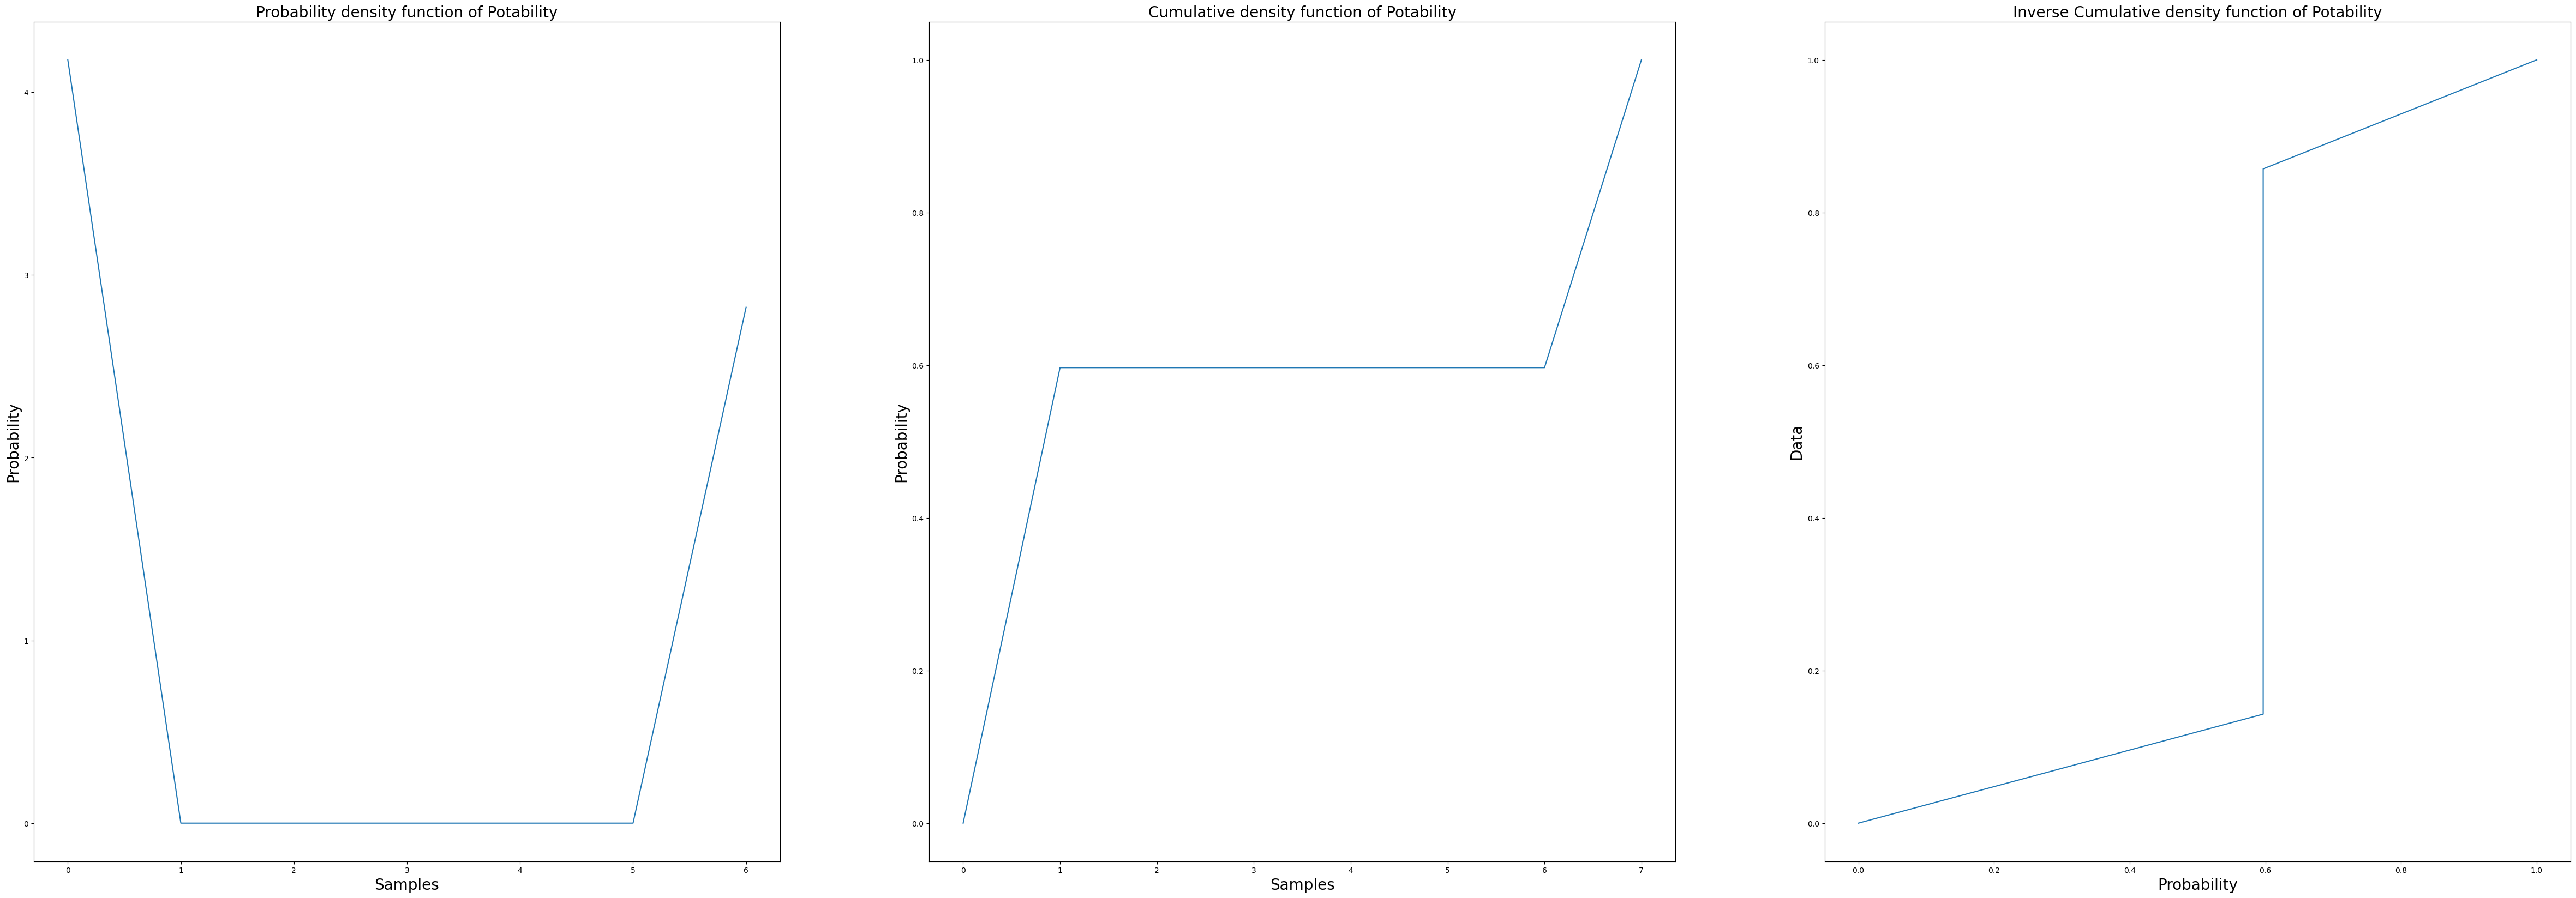

In [5]:
from seaborn import distributions

for name in targets.columns:
    bins = distributions._freedman_diaconis_bins(source_df[name].values)
    hist, bin_edges = np.histogram(source_df[name], bins=bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))


    plt.figure(figsize=(60, 20))
    plt.subplot(1,3,1)
    plt.plot(hist)
    plt.ylabel('Probability', fontsize=20)
    plt.xlabel('Samples', fontsize=20)
    plt.title(f"Probability density function of {name}", fontsize=20)


    plt.subplot(1,3,2)
    plt.plot(cum_values)
    plt.ylabel('Probability', fontsize=20)
    plt.xlabel('Samples', fontsize=20)
    plt.title(f"Cumulative density function of {name}", fontsize=20)

    plt.subplot(1,3,3)
    plt.plot(cum_values, bin_edges)
    plt.ylabel('Data', fontsize=20)
    plt.xlabel('Probability', fontsize=20)
    plt.title(f"Inverse Cumulative density function of {name}", fontsize=20)
    plt.savefig(f'./Pictures/INTF_{name}_1', bbox_inches='tight')

    plt.show()

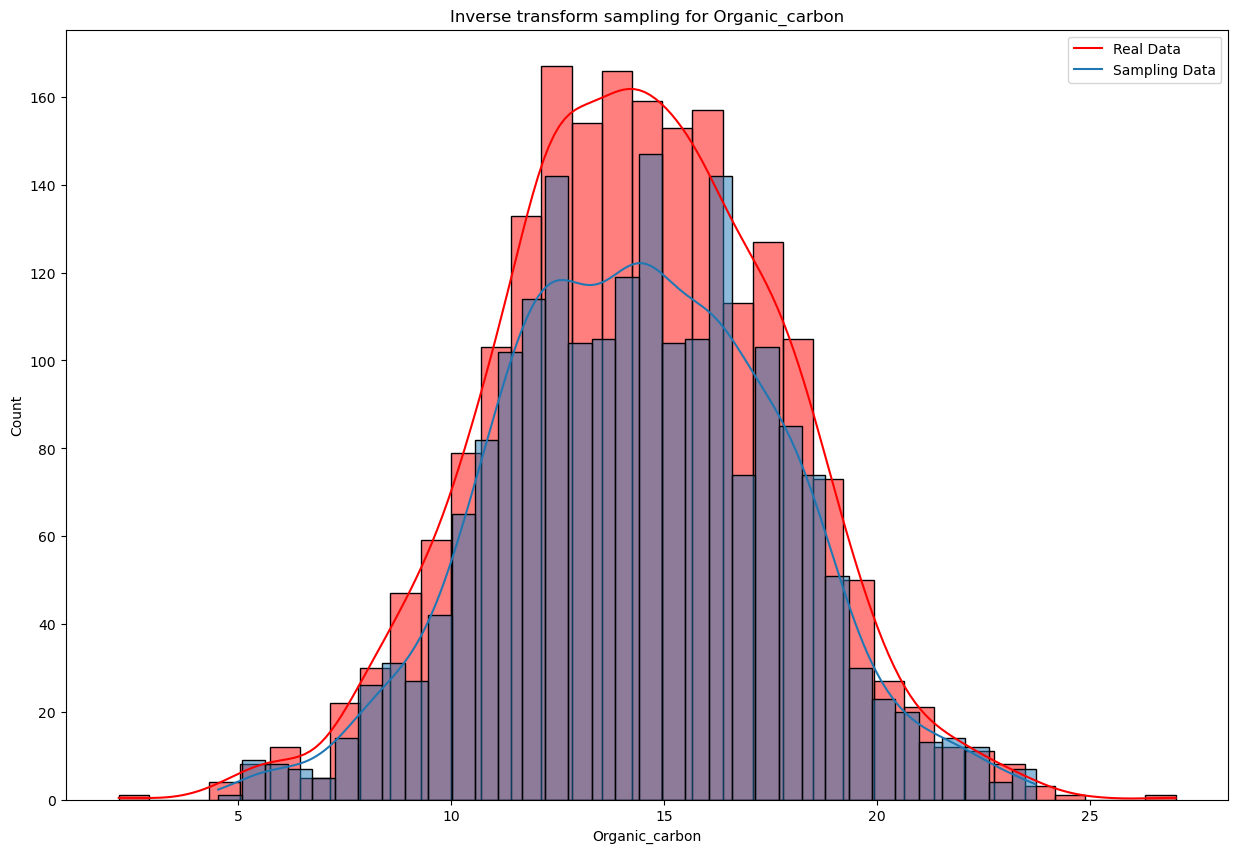

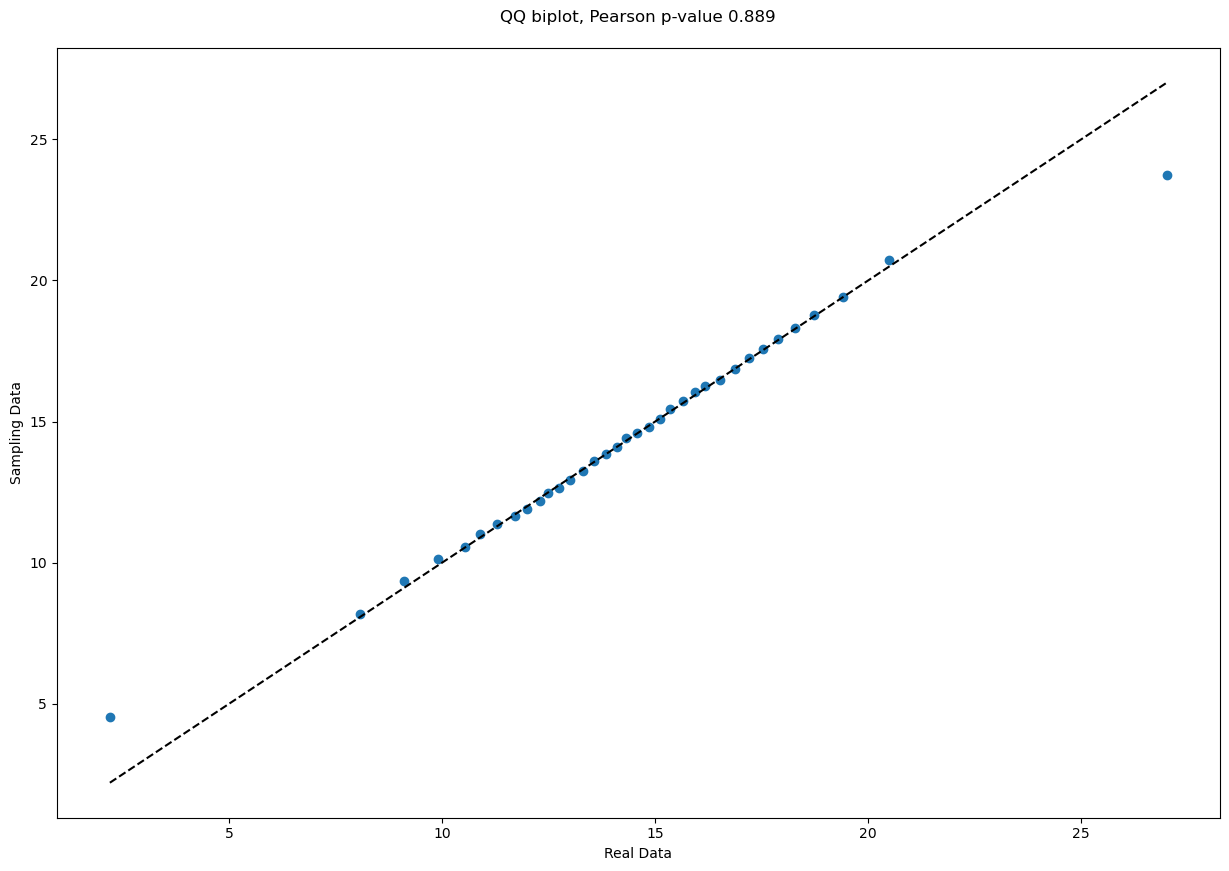

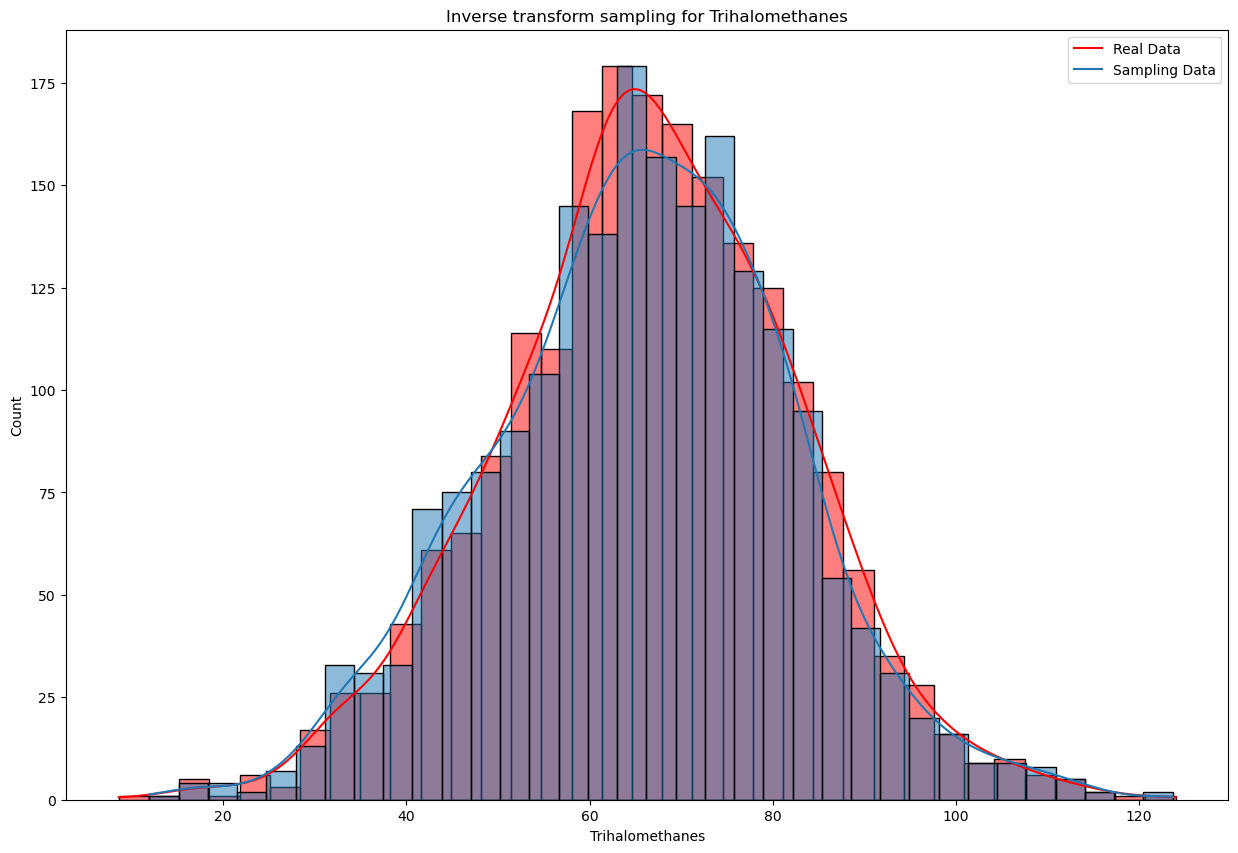

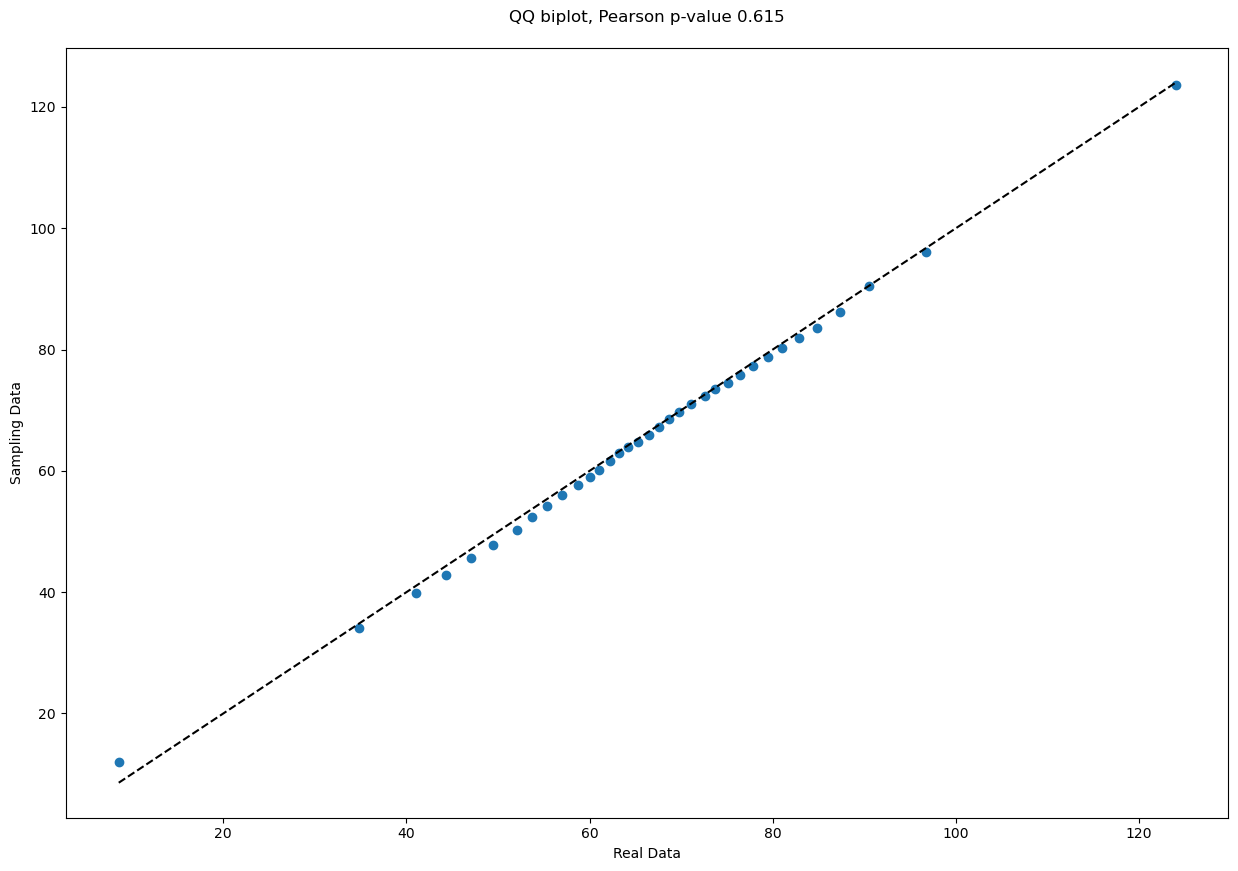

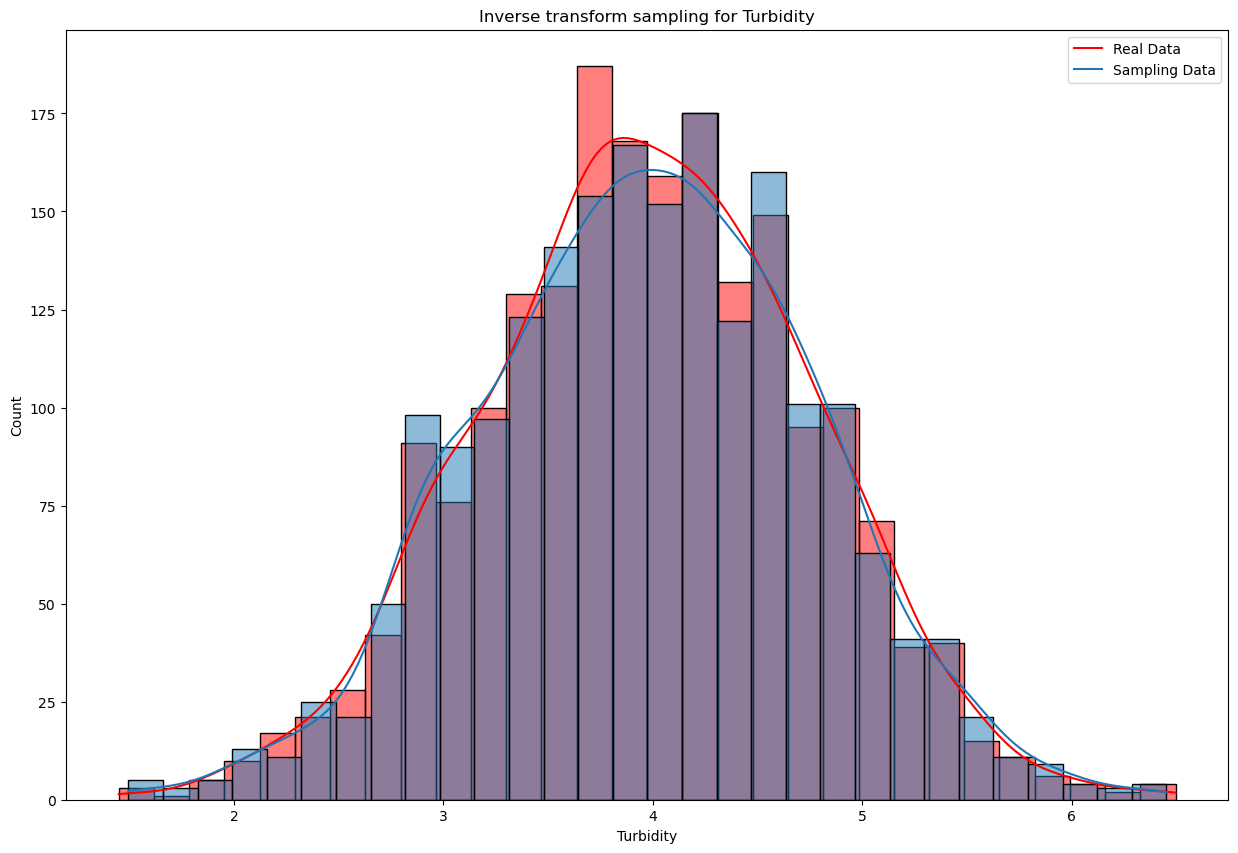

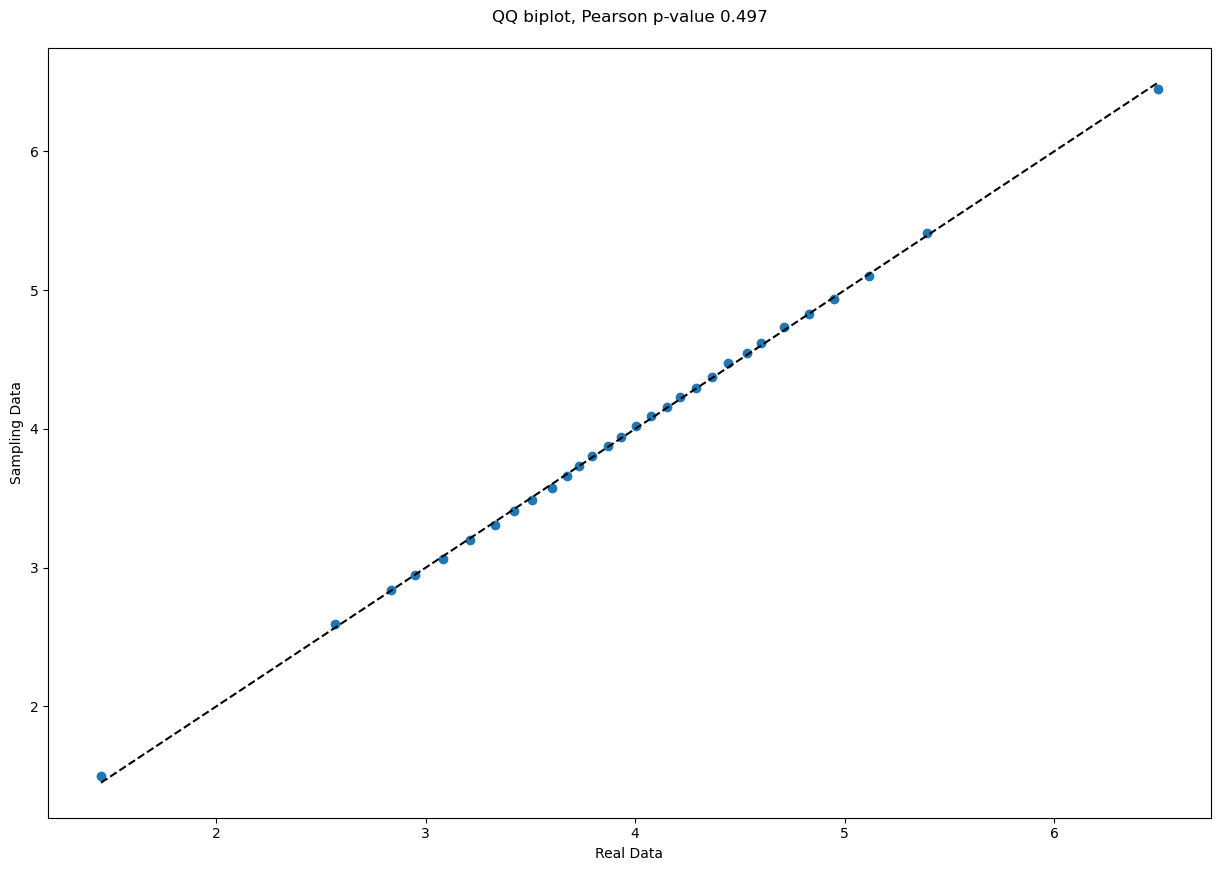

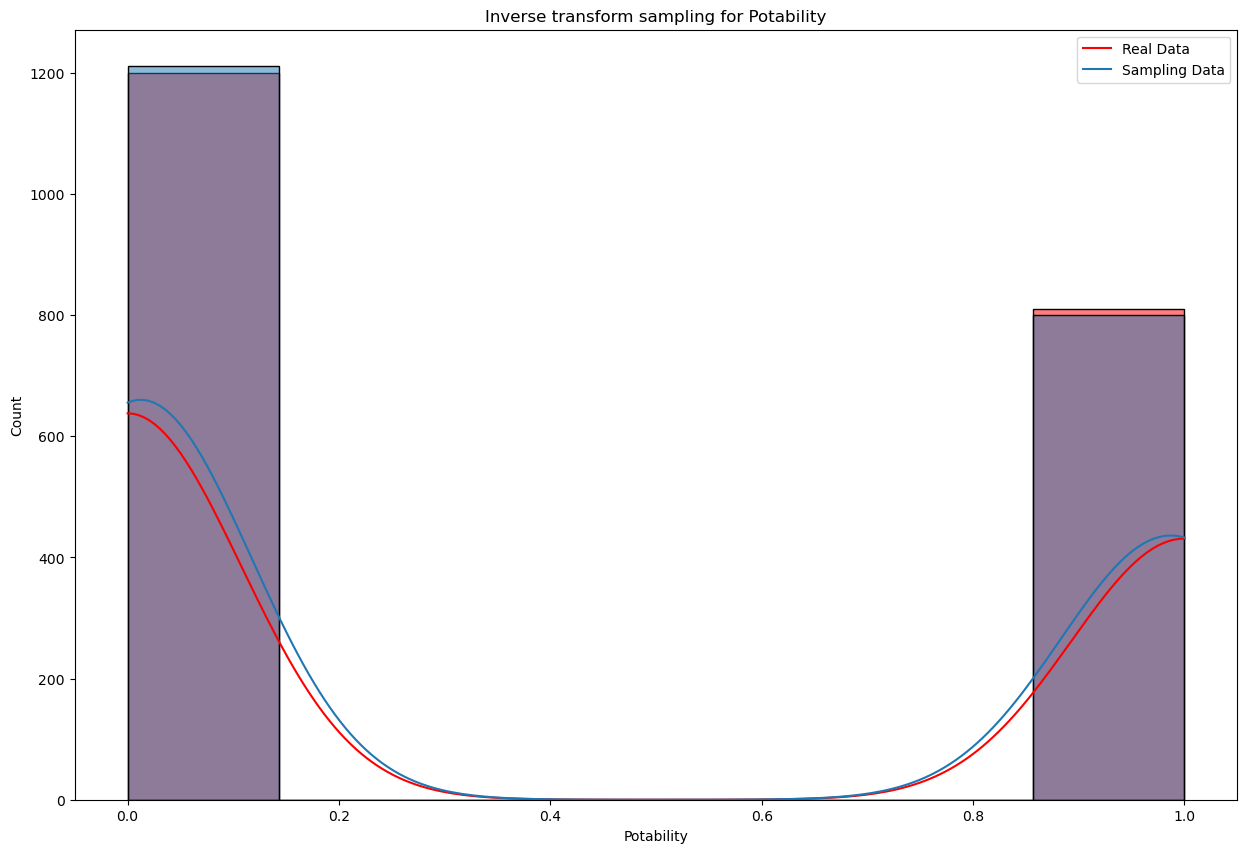

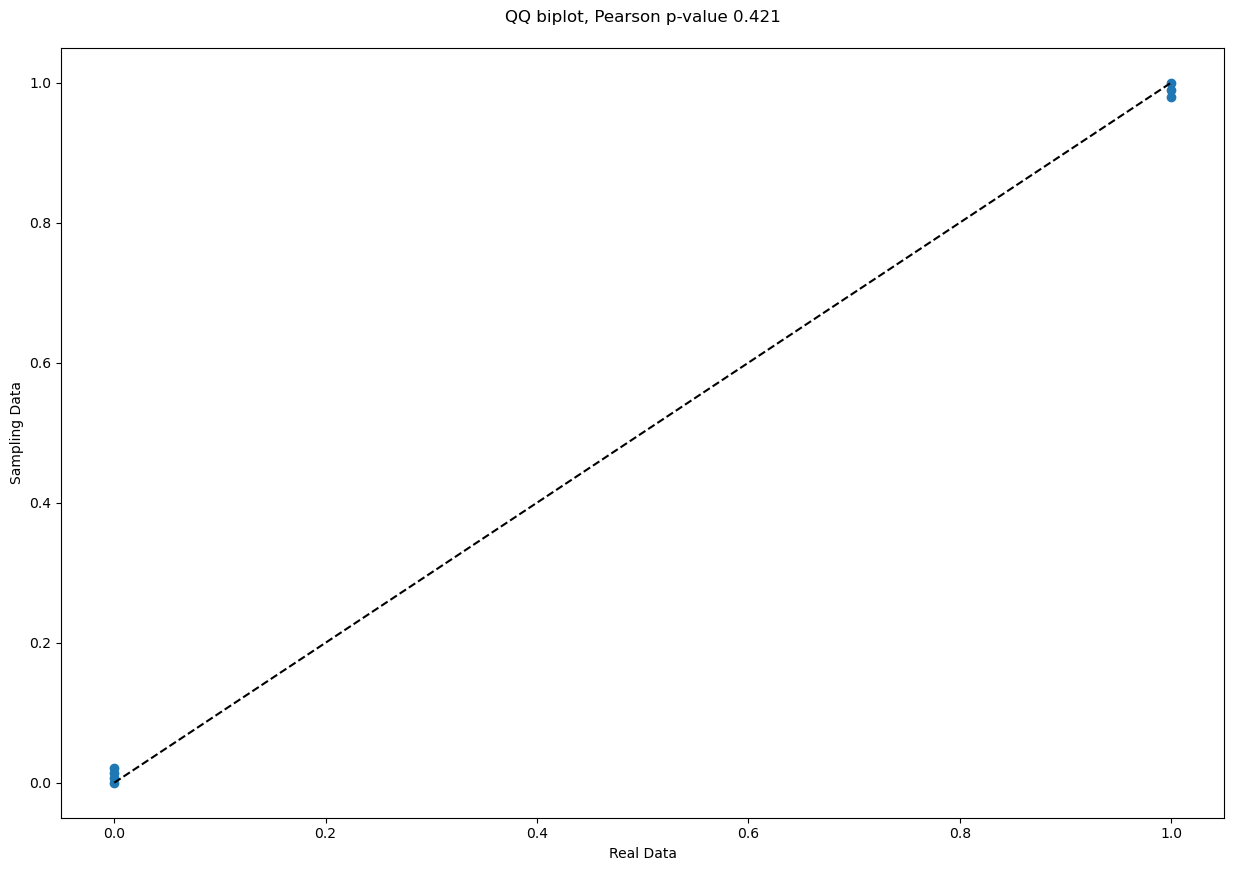

In [6]:
for name in targets.columns:
    sampled, n_bins = inverse_transform_sampling(source_df[name], n_samples=source_df[name].shape[0])

    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(source_df[name], percs)
    qn_sampled = np.percentile(sampled, percs)

    p_stat, p_pv = scipy.stats.pearsonr(source_df[name], sampled)

    plt.figure(figsize=(15, 10))
    sns.histplot(source_df[name], bins=n_bins, kde=True, color='r')
    sns.histplot(sampled, bins=n_bins, kde=True)
    plt.legend(["Real Data", 'Sampling Data'])
    plt.title(f"Inverse transform sampling for {name}")
    plt.savefig(f'IV_plot_{name}', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
    plt.plot(qn_gt, qn_gt, color="k", ls="--")
    plt.xlabel("Real Data")
    plt.ylabel("Sampling Data")
    plt.title(f"QQ biplot, Pearson p-value {p_pv:.3f}\n")
    plt.savefig(f'Probability_plot_{name}', bbox_inches='tight')
    plt.show()
    

In [7]:
import random
def accept_reject_sampling (data, distribution,col_name):
    # plotting the original data
    plt.figure(figsize=(8,8))
    min_value, max_value = data.min(), data.max()
    x = np.linspace(min_value, max_value, len(data))
    data.hist(density=True,stacked=True,bins=20, label='Original Data')
    MLE_params = distribution.fit(data)
    values = distribution.pdf(x,*MLE_params)
    plt.plot(x,values,label=distribution.__class__.__name__)
    N = 1000000
    S = 10
    samples = np.random.normal(data.mean(), data.std(), size=(N,))
    accept = distribution.pdf(samples,*MLE_params) / (S*norm.pdf(samples,data.mean(), data.std()) + 1e-3)
    mask = np.random.random(size=(N,)) < accept
    samples = samples[mask]
    plt.hist(samples, bins=20, density=True,alpha=0.4, color='orange', label='Sampled Data')
    plt.title(col_name)
    plt.legend()
    plt.show()
#---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 
    n_bins = 30
    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(data, percs)
    qn_sampled = np.percentile(samples, percs)
    
    size = len(data)
    samples = samples[:size]

    print(len(data))
    print(len(samples))
    p_stat, p_pv = scipy.stats.pearsonr(data, samples)
    
    plt.figure(figsize=(15, 10))
    plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
    plt.plot(qn_gt, qn_gt, color="k", ls="--")
    plt.xlabel("Real Data")
    plt.ylabel("Sampling Data")
    plt.title(f"QQ biplot, Pearson p-value {p_pv:.3f}\n")
    plt.savefig(f'Probability_plot_{name}', bbox_inches='tight')
    plt.show()
    

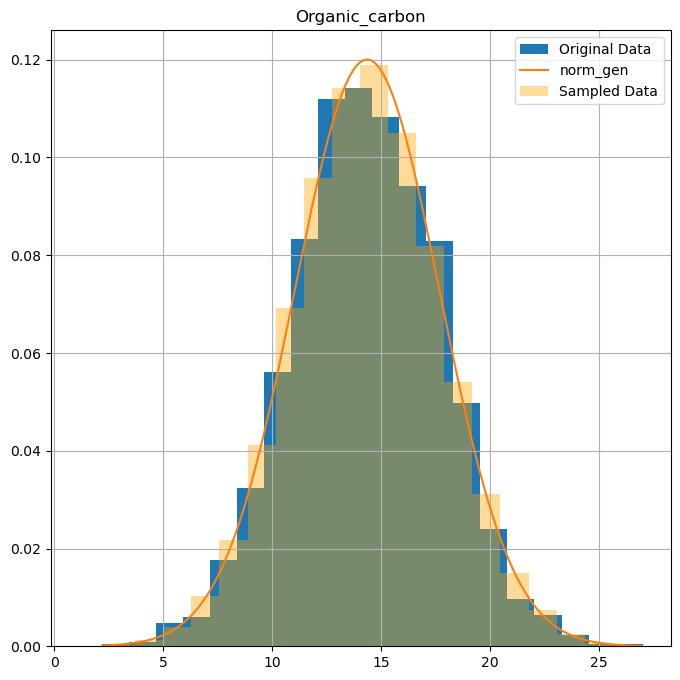

2011
2011


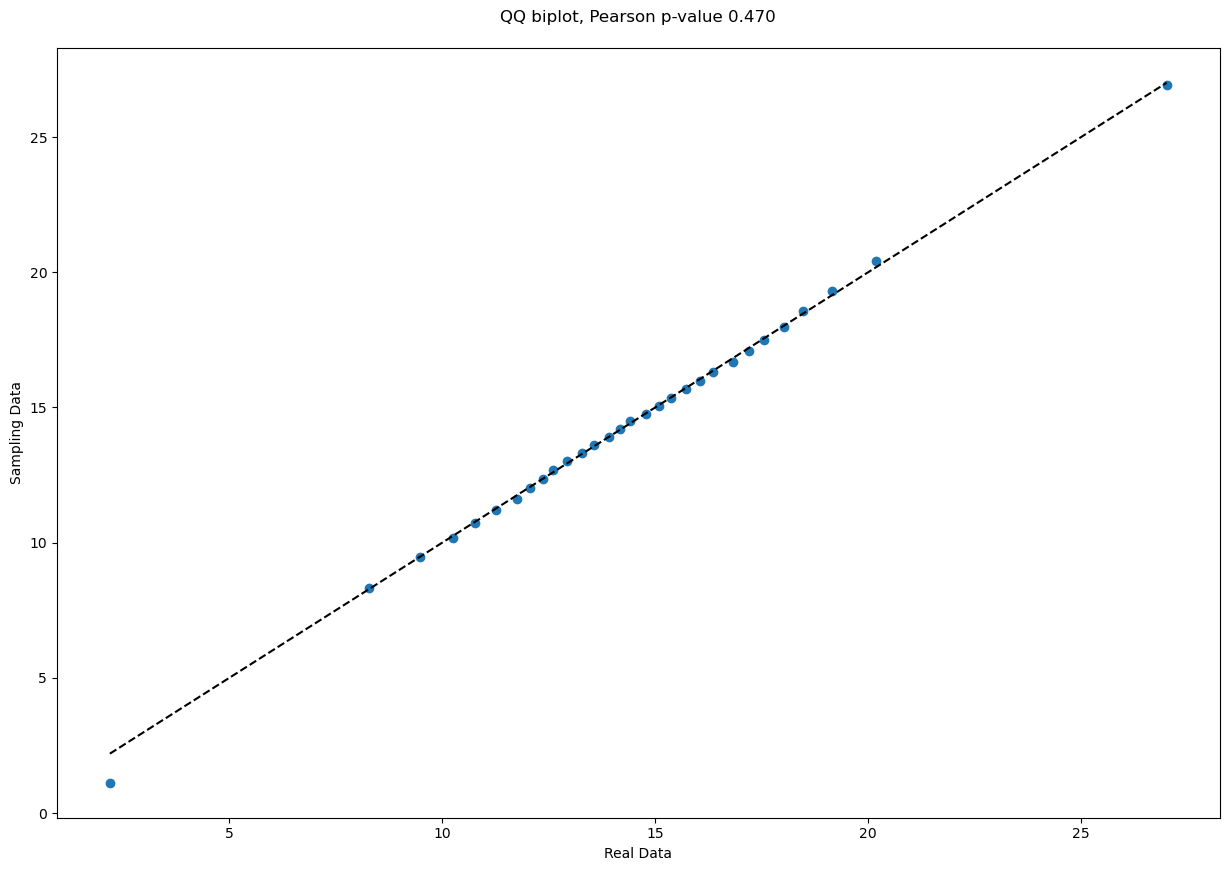

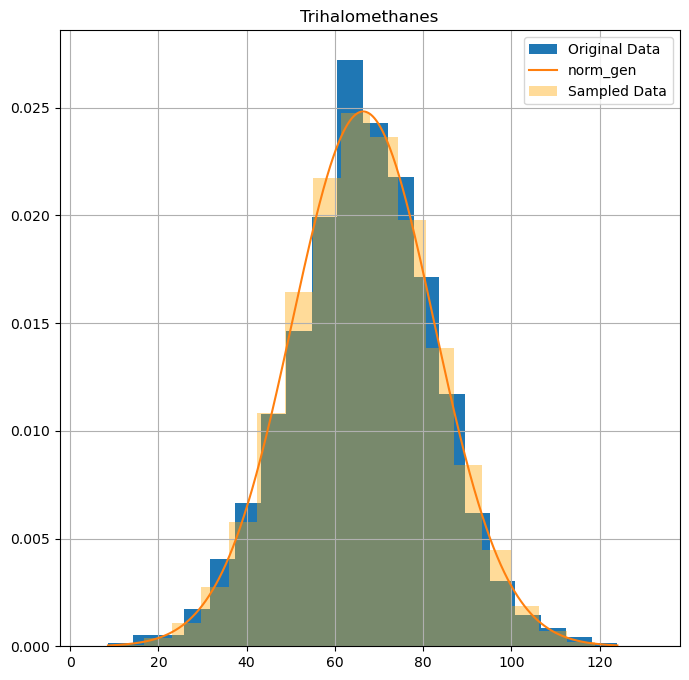

2011
2011


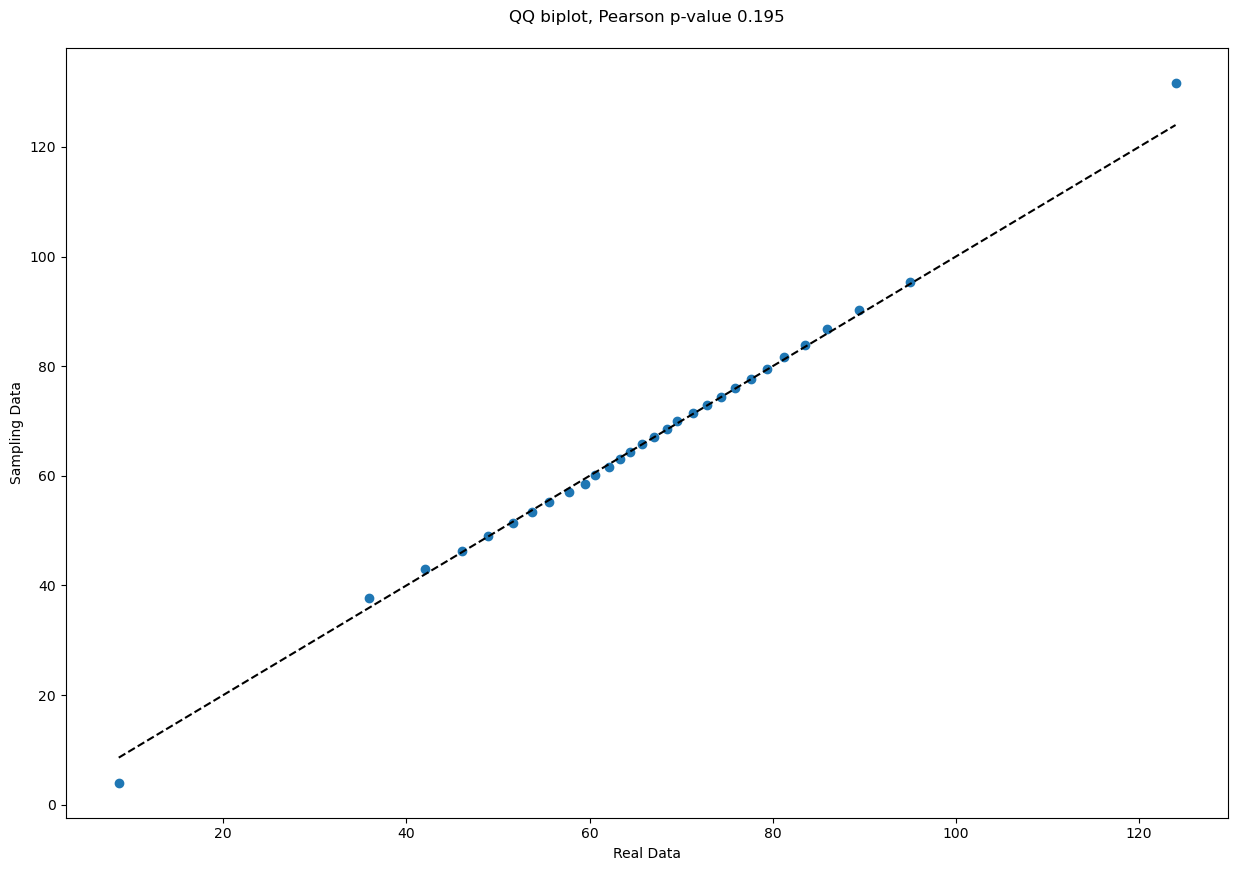

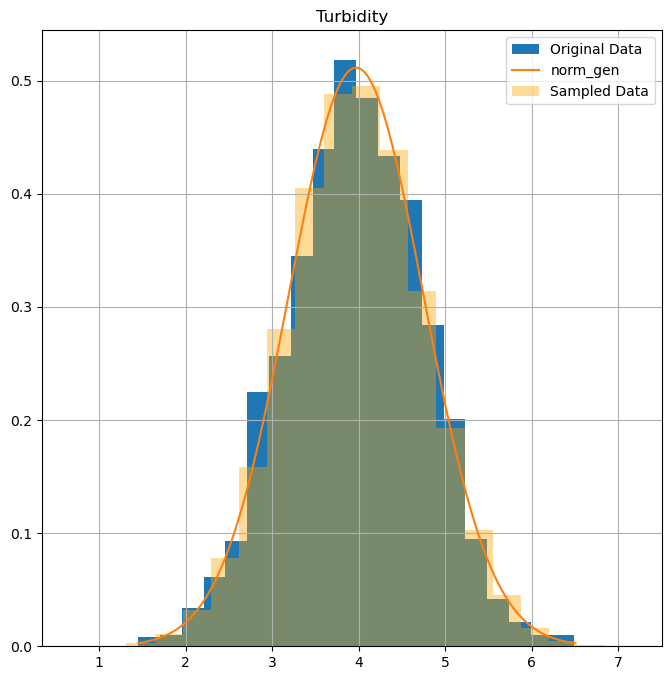

2011
2011


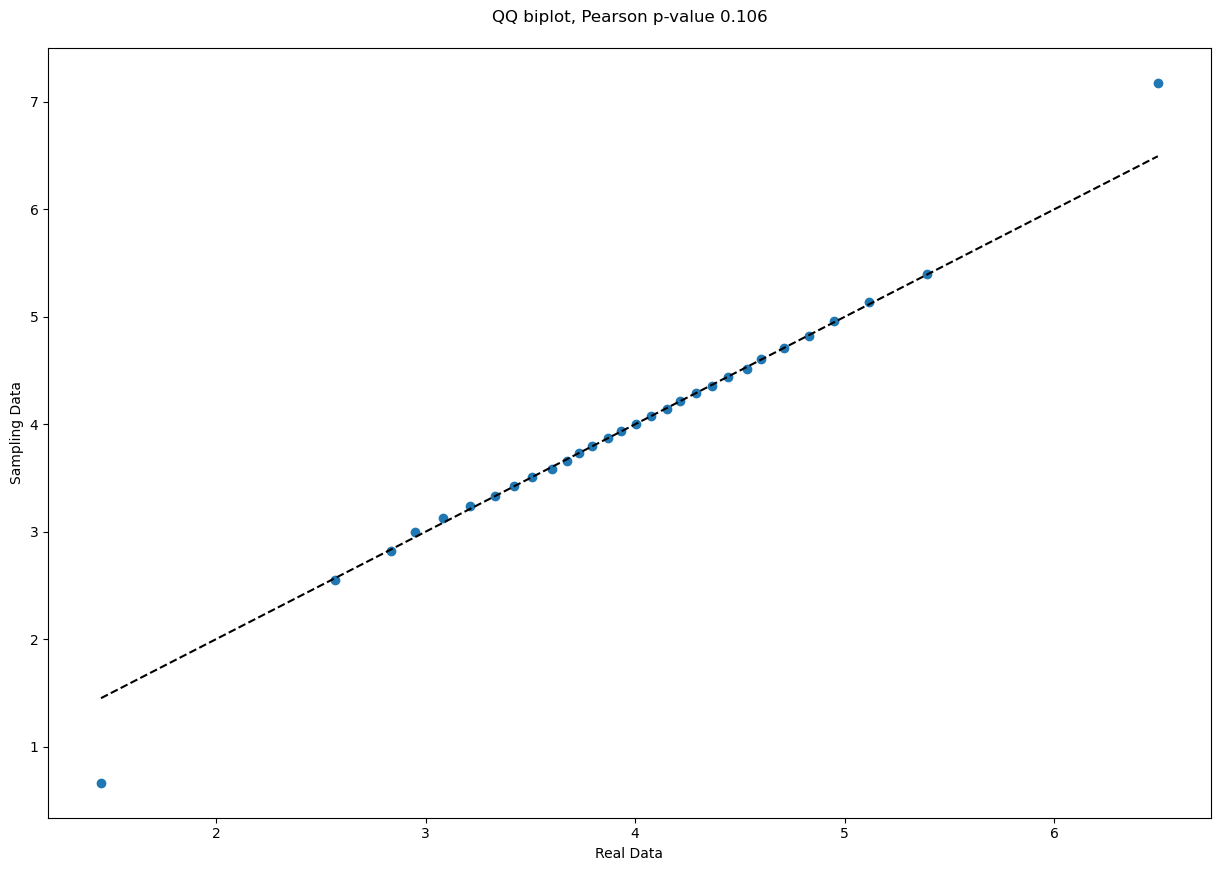

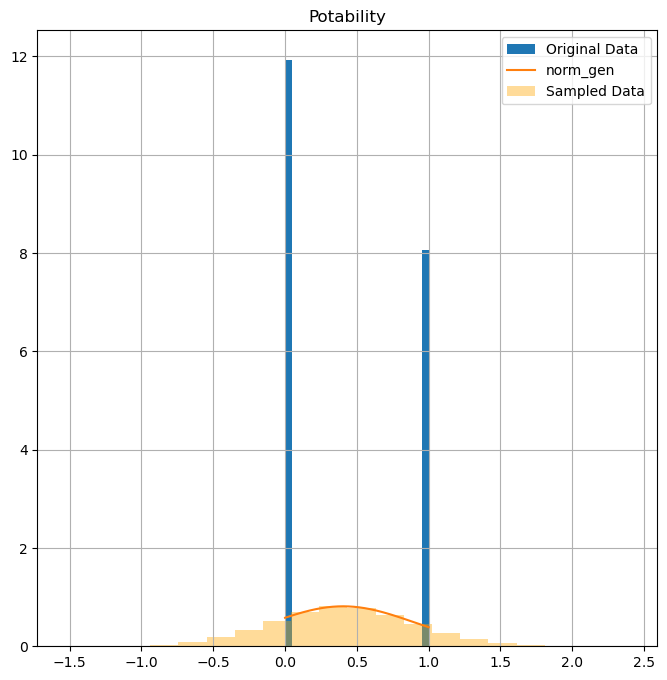

2011
2011


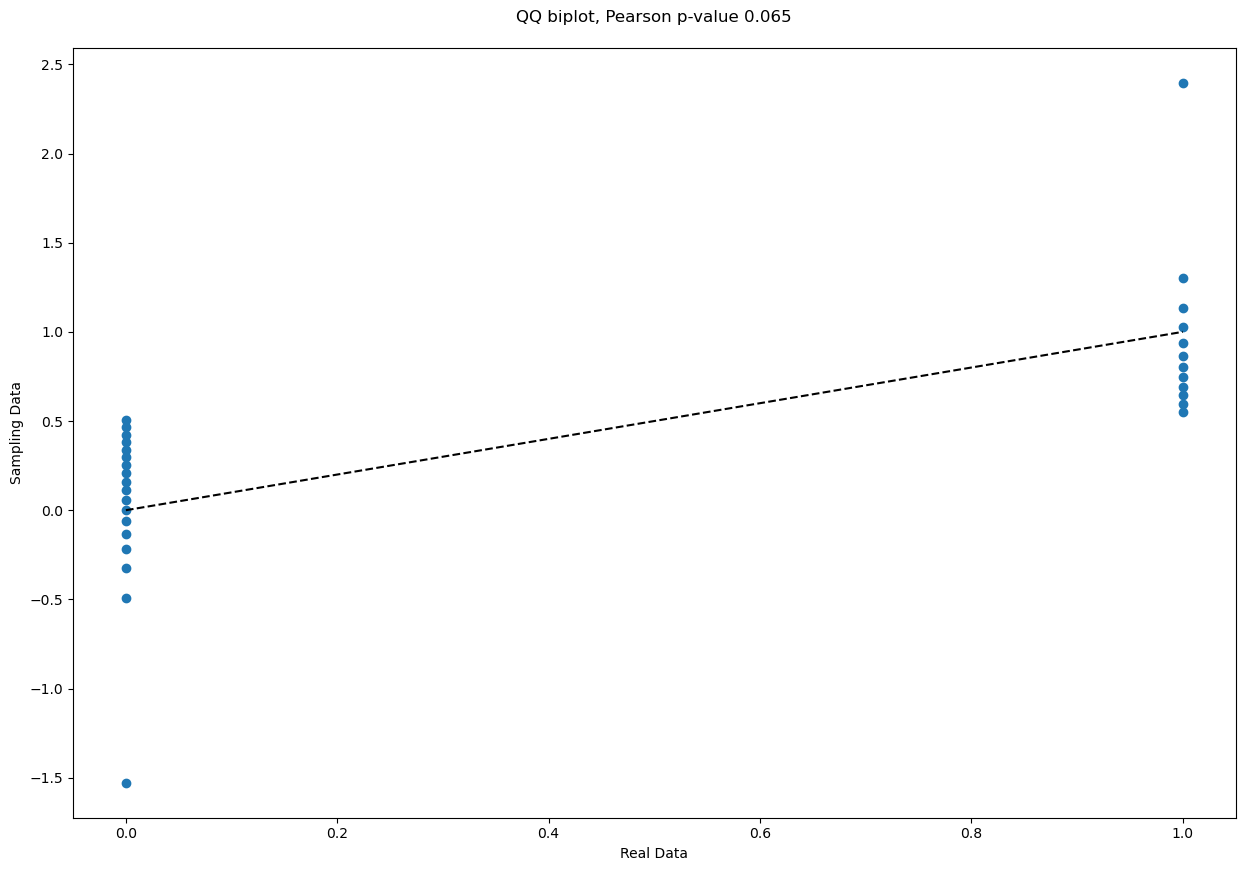

In [8]:
from scipy.stats.distributions import norm
for name in targets.columns:
    accept_reject_sampling(source_df[name],norm,name)

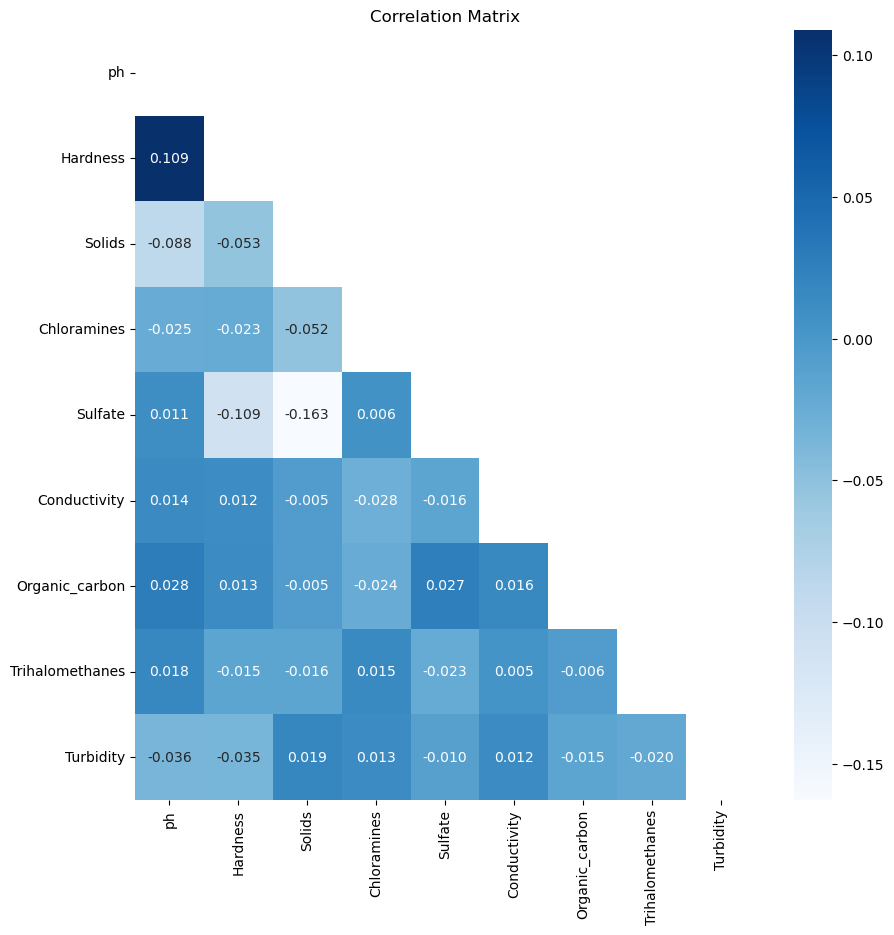

In [38]:
#Pair correlation coefficients, Correlation Matrix
fig, ax = plt.subplots(figsize=(10,10))
corr = source_df[source_df.columns[:-1]].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True,  fmt='.3f',ax=ax, cmap = 'Blues')
plt.title('Correlation Matrix')
plt.show()


In [10]:

discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans")

data_descrete = discretizer.fit_transform(variables.values)
data_descrete = pd.DataFrame(data_descrete, columns=variables.columns)

data_descrete.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity
0,3.0,3.0,2.0,3.0,3.0,1.0
1,3.0,1.0,1.0,1.0,1.0,1.0
2,1.0,2.0,3.0,2.0,2.0,0.0
3,4.0,4.0,3.0,2.0,4.0,0.0
4,3.0,2.0,0.0,0.0,1.0,3.0


In [11]:
model = BayesianModel([
    ('Sulfate', 'Organic_carbon'),
    ('Conductivity', 'Organic_carbon'),
    ('ph', 'Trihalomethanes'),
    ('Solids', 'Turbidity'),
    ('Chloramines', 'Turbidity'),
    ('Conductivity', 'Turbidity')
])

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


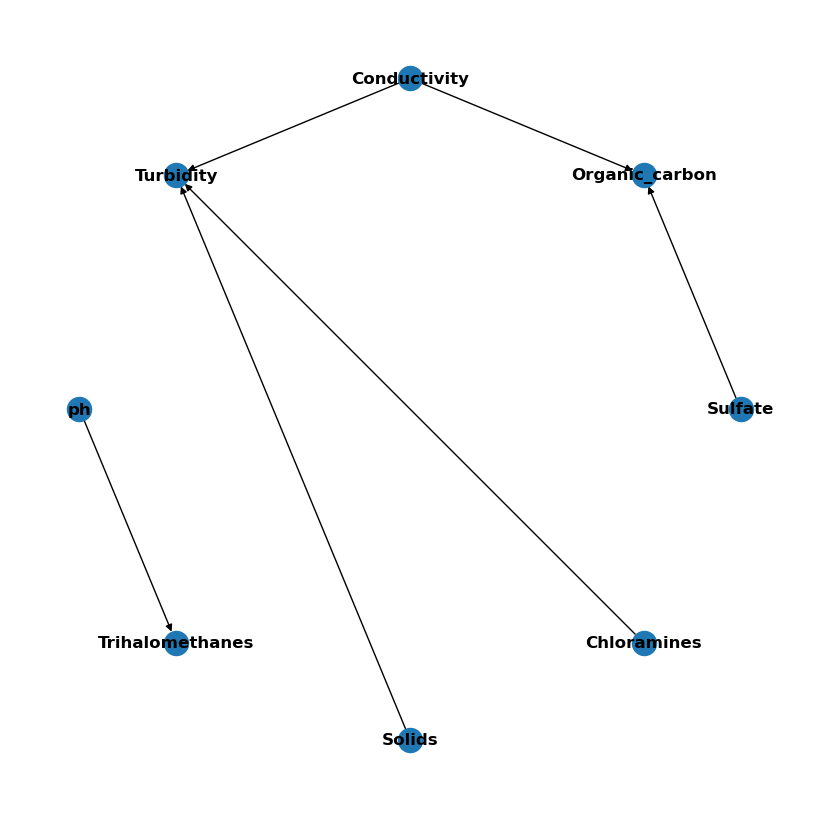

In [12]:
import networkx as nx

network = nx.DiGraph()
network.add_edges_from(model.edges())
pos = nx.layout.circular_layout(network)
plt.figure(figsize=(8, 8))
nx.draw(network, pos, with_labels=True, font_weight="bold")

In [13]:
df_transformed = source_df.copy()
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(source_df.values[:,:])
df_transformed = df_discretized
df_transformed = pd.DataFrame(df_transformed, columns=source_df.columns)
df_transformed.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0


In [14]:
hc_search = HillClimbSearch(data = df_transformed)
hc_k2 = hc_search.estimate(scoring_method=K2Score(df_transformed))
hc_bic = hc_search.estimate(scoring_method=BicScore(df_transformed))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

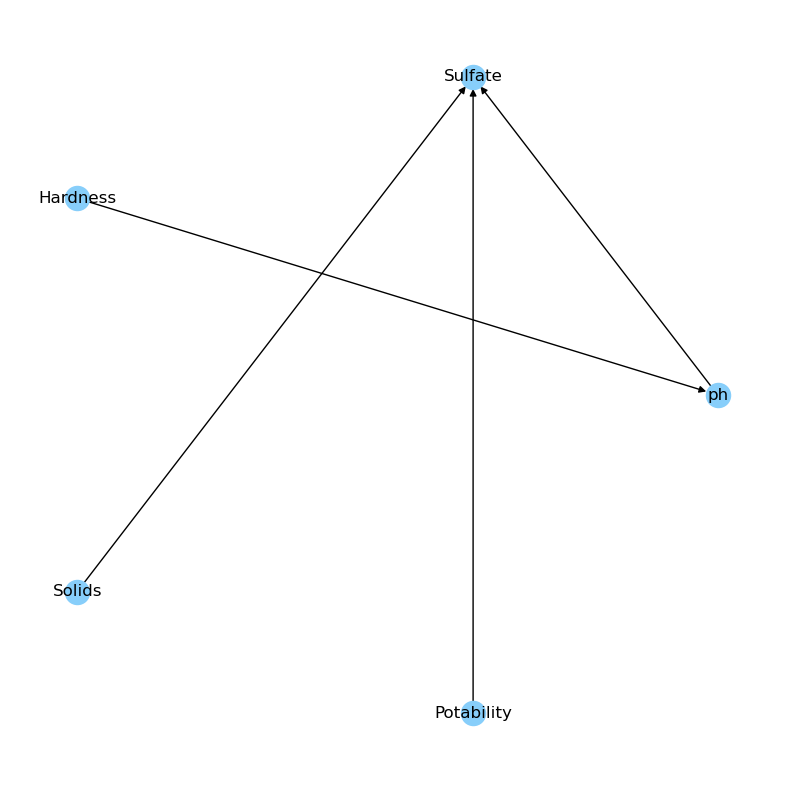

In [15]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_k2.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue')

plt.show()

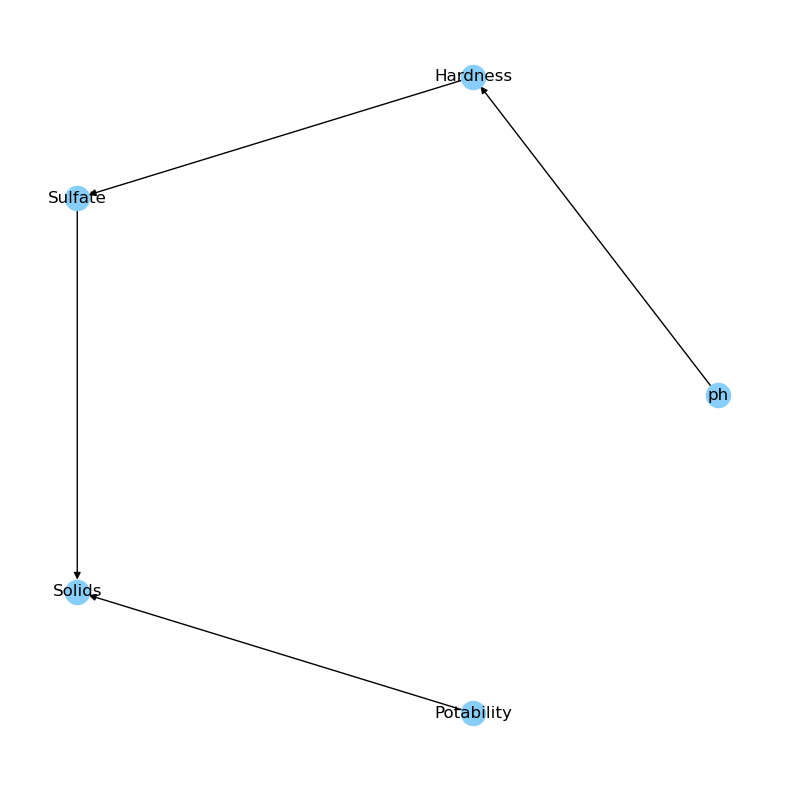

In [16]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_bic.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue')

plt.show()

In [17]:
e_search = TreeSearch(data=df_transformed)
e_model = e_search.estimate()

Building tree:   0%|          | 0/45.0 [00:00<?, ?it/s]

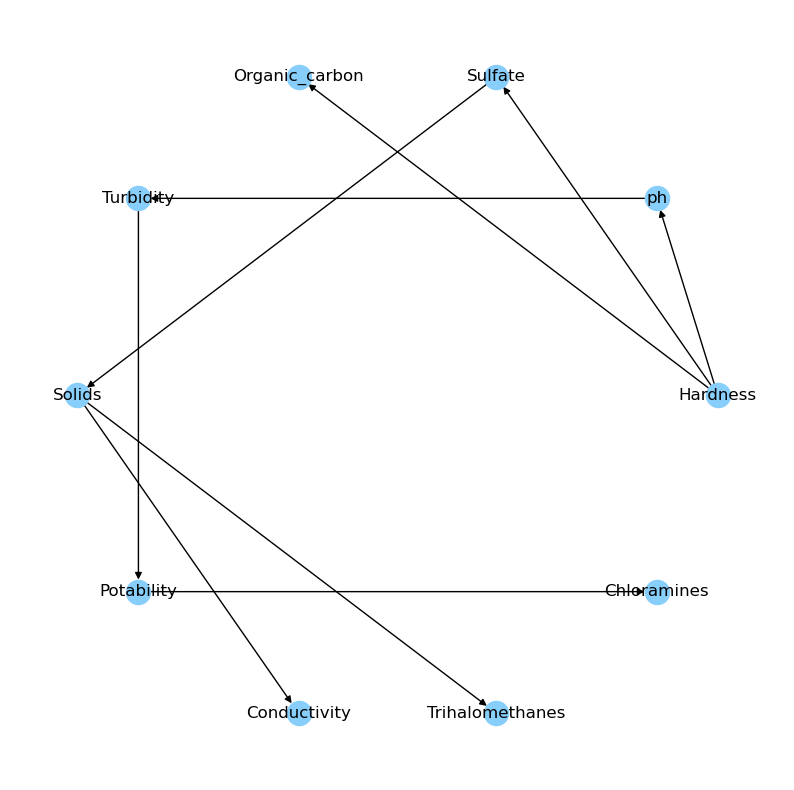

In [18]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(e_model.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue')

plt.show()

In [19]:
def return_sample(model, data, size):
    model_s = BayesianModel(model.edges())
    model_s.fit(data)    
    sampling = BayesianModelSampling(model_s)
    sample = sampling.forward_sample(size=size)
    return sample

In [20]:
sample_hc = return_sample(hc_k2, df_transformed, df_transformed.shape[0])
sample_e = return_sample(e_model, df_transformed, df_transformed.shape[0])
sample_our = return_sample(model, df_transformed, df_transformed.shape[0])

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

In [21]:
print(classification_report(df_transformed.ph, sample_hc.ph))

              precision    recall  f1-score   support

         0.0       0.54      0.55      0.55      1077
         1.0       0.47      0.46      0.47       934

    accuracy                           0.51      2011
   macro avg       0.51      0.51      0.51      2011
weighted avg       0.51      0.51      0.51      2011



In [22]:
print(classification_report(df_transformed.ph, sample_e.ph))

              precision    recall  f1-score   support

         0.0       0.54      0.55      0.54      1077
         1.0       0.47      0.46      0.47       934

    accuracy                           0.51      2011
   macro avg       0.51      0.51      0.51      2011
weighted avg       0.51      0.51      0.51      2011



In [23]:
print(classification_report(df_transformed.ph, sample_our.ph))

              precision    recall  f1-score   support

         0.0       0.52      0.52      0.52      1077
         1.0       0.45      0.45      0.45       934

    accuracy                           0.49      2011
   macro avg       0.48      0.48      0.48      2011
weighted avg       0.49      0.49      0.49      2011



In [24]:
sample_hc.columns

Index(['ph', 'Sulfate', 'Hardness', 'Solids', 'Potability'], dtype='object')

In [25]:
print(classification_report(df_transformed.Sulfate, sample_hc.Sulfate))

              precision    recall  f1-score   support

         0.0       0.53      0.54      0.54      1078
         1.0       0.46      0.45      0.46       933

    accuracy                           0.50      2011
   macro avg       0.50      0.50      0.50      2011
weighted avg       0.50      0.50      0.50      2011



In [26]:
print(classification_report(df_transformed.Sulfate, sample_e.Sulfate))

              precision    recall  f1-score   support

         0.0       0.53      0.52      0.52      1078
         1.0       0.45      0.46      0.46       933

    accuracy                           0.49      2011
   macro avg       0.49      0.49      0.49      2011
weighted avg       0.49      0.49      0.49      2011



In [27]:
print(classification_report(df_transformed.Sulfate, sample_our.Sulfate))

              precision    recall  f1-score   support

         0.0       0.56      0.56      0.56      1078
         1.0       0.49      0.48      0.48       933

    accuracy                           0.53      2011
   macro avg       0.52      0.52      0.52      2011
weighted avg       0.53      0.53      0.53      2011



In [28]:
print(classification_report(df_transformed.Solids, sample_hc.Solids))

              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60      1215
         1.0       0.38      0.38      0.38       796

    accuracy                           0.51      2011
   macro avg       0.49      0.49      0.49      2011
weighted avg       0.51      0.51      0.51      2011



In [29]:
print(classification_report(df_transformed.Solids, sample_e.Solids))

              precision    recall  f1-score   support

         0.0       0.60      0.59      0.60      1215
         1.0       0.39      0.40      0.39       796

    accuracy                           0.52      2011
   macro avg       0.49      0.49      0.49      2011
weighted avg       0.52      0.52      0.52      2011



In [30]:
print(classification_report(df_transformed.Solids, sample_our.Solids))

              precision    recall  f1-score   support

         0.0       0.60      0.61      0.61      1215
         1.0       0.40      0.39      0.39       796

    accuracy                           0.52      2011
   macro avg       0.50      0.50      0.50      2011
weighted avg       0.52      0.52      0.52      2011



In [31]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame, axes=None):
    final_df = pd.DataFrame()
    
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    
    sns.barplot(ax=axes, x=parametr, y="Probability", hue="Data", data=final_df)

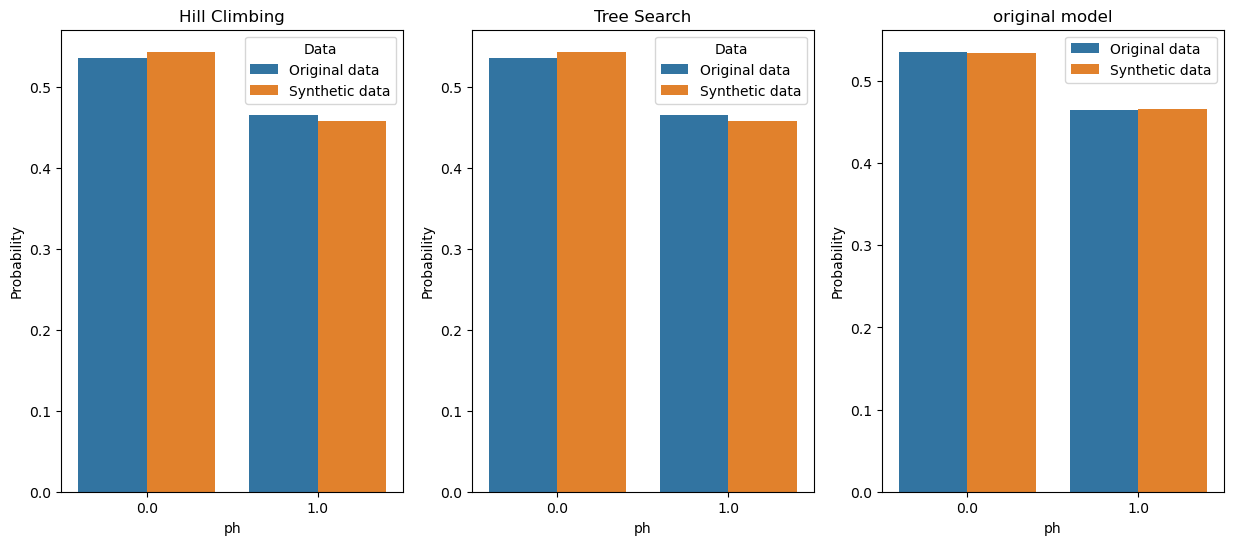

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

draw_comparative_hist('ph', df_transformed, sample_hc, axes=axes[0])
draw_comparative_hist('ph', df_transformed, sample_e, axes=axes[1])
draw_comparative_hist('ph', df_transformed, sample_our, axes=axes[2])

axes[0].set_title('Hill Climbing')
axes[1].set_title('Tree Search')
axes[2].set_title('original model')
plt.legend()
plt.show()

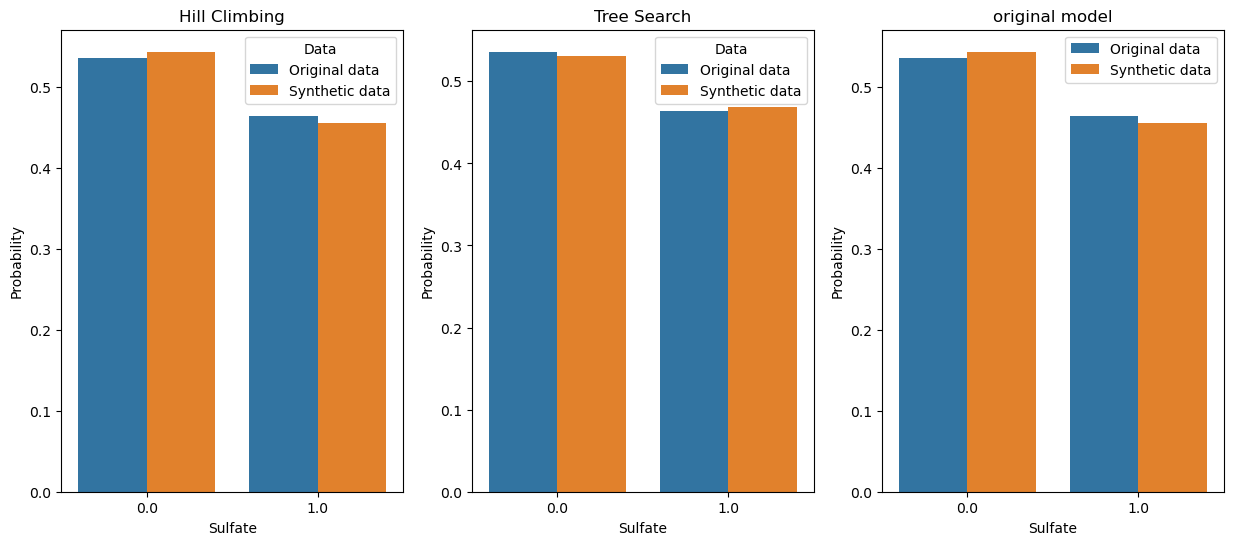

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

draw_comparative_hist('Sulfate', df_transformed, sample_hc, axes=axes[0])
draw_comparative_hist('Sulfate', df_transformed, sample_e, axes=axes[1])
draw_comparative_hist('Sulfate', df_transformed, sample_our, axes=axes[2])

axes[0].set_title('Hill Climbing')
axes[1].set_title('Tree Search')
axes[2].set_title('original model')
plt.legend()
plt.show()

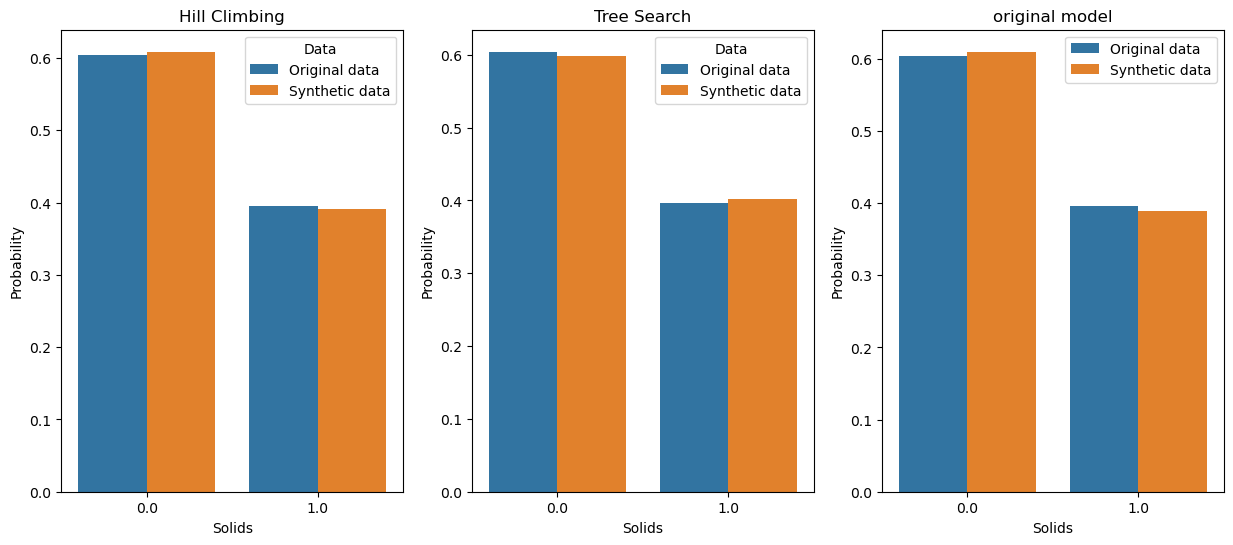

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

draw_comparative_hist('Solids', df_transformed, sample_hc, axes=axes[0])
draw_comparative_hist('Solids', df_transformed, sample_e, axes=axes[1])
draw_comparative_hist('Solids', df_transformed, sample_our, axes=axes[2])

axes[0].set_title('Hill Climbing')
axes[1].set_title('Tree Search')
axes[2].set_title('original model')
plt.legend()
plt.show()

In [35]:
sample_hc

,ph,Sulfate,Hardness,Solids,Potability
0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
2006,0.0,1.0,0.0,1.0,1.0
2007,1.0,1.0,1.0,0.0,1.0
2008,0.0,0.0,0.0,1.0,1.0
2009,0.0,0.0,0.0,1.0,1.0


In [36]:
sample_e


,Hardness,ph,Sulfate,Organic_carbon,Turbidity,Solids,Potability,Conductivity,Trihalomethanes,Chloramines
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2006,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2007,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2008,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2009,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0


In [37]:
sample_our

,Sulfate,Organic_carbon,Conductivity,Turbidity,ph,Trihalomethanes,Solids,Chloramines
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
2006,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2007,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2008,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2009,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
